In [3]:
!pip install torch_snippets
from torch_snippets import *
from torchvision import transforms as T
from torch.nn import functional as F
from torchvision.models import vgg19
import torch.nn as nn
device = 'cpu'

In [5]:
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    T.Lambda(lambda x: x.mul_(255))
])
postprocess = T.Compose([
    T.Lambda(lambda x: x.mul_(1./255)),
    T.Normalize(mean=[-0.485/0.229, -0.456/0.224,-0.406/0.225], std=[1/0.229,1/0.224,1/0.255]),
])

In [7]:
class GramMatrix(nn.Module):
    def forward(self,input):
        b,c,h,w = input.size()
        feat = input.view(b,c,h*w)
        G = feat@feat.transpose(1,2)
        G.div_(h*w)
        return G
class GramMSELoss(nn.Module):
    def forward(self,input,target):
        out = F.mse_loss(GramMatrix()(input),target)
        return(out)
class vgg19_modified(nn.Module):
    def __init__(self):
        super().__init__()
        features = list(vgg19(pretrained=True).features)
        self.features = nn.ModuleList(features).eval()
    
    def forward(self, x, layers=[]):
        if not layers:
            return x
        order = np.argsort(layers)
        _results, results = [], []
        
        for ix, model in enumerate(self.features):
            x = model(x)
            if ix in layers:
                _results.append(x)
        
        # Organizar os resultados na ordem especificada por `order`
        for o in order:
            results.append(_results[o])
        
        return results

In [68]:
vgg = vgg19_modified().to(device)

In [44]:
!wget https://easydrawingguides.com/wp-content/uploads/2016/10/how-to-draw-an-elephant-featured-image-1200.png
!wget https://www.neh.gov/sites/default/files/2022-09/Fall_2022_web-images_Picasso_32.jpg

--2025-01-19 18:01:14--  https://easydrawingguides.com/wp-content/uploads/2016/10/how-to-draw-an-elephant-featured-image-1200.png
Resolvendo easydrawingguides.com (easydrawingguides.com)... 104.16.151.108, 104.16.150.108
Conectando-se a easydrawingguides.com (easydrawingguides.com)|104.16.151.108|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 56936 (56K) [image/png]
Salvando em: “how-to-draw-an-elephant-featured-image-1200.png”

how-to-draw-an-elep 100%[===================>]  55,60K  --.-KB/s    em 0,004s  

2025-01-19 18:01:14 (12,5 MB/s) - “how-to-draw-an-elephant-featured-image-1200.png” salvo [56936/56936]

--2025-01-19 18:01:14--  https://www.neh.gov/sites/default/files/2022-09/Fall_2022_web-images_Picasso_32.jpg
Resolvendo www.neh.gov (www.neh.gov)... 23.21.228.79
Conectando-se a www.neh.gov (www.neh.gov)|23.21.228.79|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 5309491 (5,1M) [image/jpeg]
Salva

In [48]:
imgs = [Image.open(path).resize((512,512)).convert('RGB') for path in ['picasso.jpg',
                                                                       'elephant.png']]
style_image, content_image = [preprocess(img).to(device)[None] for img in imgs]

In [50]:
opt_img = content_image.data.clone()
opt_img.requires_grad = True

In [52]:
style_layers = [0, 5, 10, 19, 28]
content_layers = [21]
loss_layers = style_layers + content_layers

In [54]:
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]

In [56]:
style_weights = [1000/n**2 for n in [64,128,256,512,512]]
content_weights = [1]
weights = style_weights + content_weights

In [70]:
style_target = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_target + content_targets

In [72]:
import torch.optim as optim
max_iters = 500
optimizer = optim.LBFGS([opt_img])

In [74]:
iters = 0
while iters < max_iters:
    def closure():
        global iters
        iters += 1
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        return loss
    optimizer.step(closure)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2892203..1.917705].


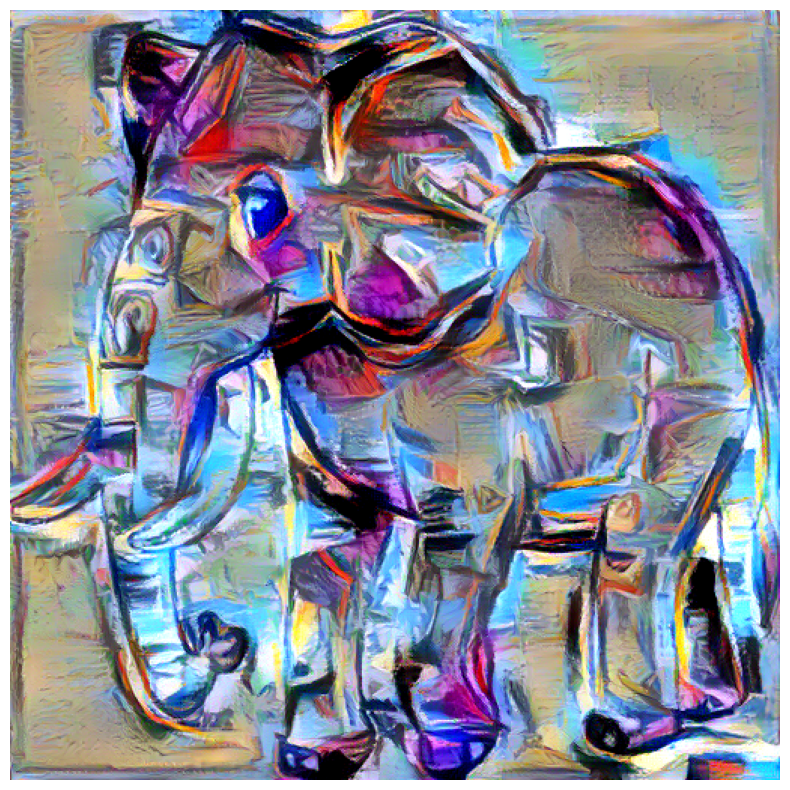

In [75]:
import torch

with torch.no_grad():
    out_img = postprocess(opt_img[0]).permute(1,2,0)

show(out_img)